# HW 5: Forecasting Dynamics of Lorenz Equations
Shaunak Bhide

In [1]:
#import cell
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

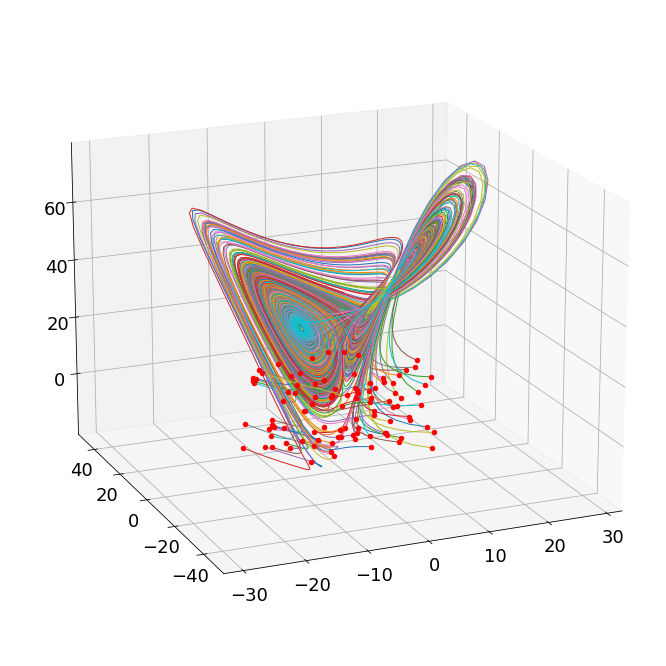

In [63]:
#Lorenz equation
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 35


nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])



for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

In [64]:
#Training a FFNN 

#make the architecture
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the loss function
criterion = nn.MSELoss()

# Define tolerable loss
loss_acceptable = 0.009

# Define the training data and create a PyTorch DataLoader object
train_data = TensorDataset(torch.from_numpy(nn_input).float(), torch.from_numpy(nn_output).float())
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Instantiate the network, optimizer, and set the device to GPU if available
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Train the network
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    curr_loss = running_loss/len(train_loader)

    # check if the loss is below an acceptable threshold. 
    if (curr_loss <= loss_acceptable) : 
        print('FFNN: Epoch %d loss has reached the acceptable loss threshold. loss: %.3f' % (epoch+1, curr_loss))
        break
    else :
        print('Epoch %d loss: %.3f' % (epoch+1, curr_loss))

#save the model
torch.save(net.state_dict(), 'model35.pth')

Epoch 1 loss: 3.443
Epoch 2 loss: 0.090
Epoch 3 loss: 0.057
Epoch 4 loss: 0.039
Epoch 5 loss: 0.034
Epoch 6 loss: 0.029
Epoch 7 loss: 0.026
Epoch 8 loss: 0.023
Epoch 9 loss: 0.020
Epoch 10 loss: 0.019
Epoch 11 loss: 0.017
Epoch 12 loss: 0.015
Epoch 13 loss: 0.015
Epoch 14 loss: 0.014
Epoch 15 loss: 0.013
Epoch 16 loss: 0.011
Epoch 17 loss: 0.012
Epoch 18 loss: 0.011
Epoch 19 loss: 0.010
Epoch 20 loss: 0.010
Epoch 21 loss: 0.009
Epoch 22 loss: 0.009
FFNN: Epoch 23 loss has reached the acceptable loss threshold. loss: 0.008


In [77]:
# Evaluate the model for future state prediction for ρ=17 and ρ=35
# create a new instance of the same model
net = Net()

# load the saved model's state dict
net.load_state_dict(torch.load('model17.pth'))

test_input = torch.cat([torch.tensor(x_t[:, -1, :], dtype=torch.float32),
                        torch.tensor([[17, 17, 17]], dtype=torch.float32)])[:-1]
test_output = torch.tensor(x_t[:, -1, :], dtype=torch.float32)


test_dataset = TensorDataset(test_input, test_output)



# Evaluate the model on the test data
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    test_loss17 = 0.0
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        test_loss17 += criterion(outputs, labels).item() * inputs.shape[0]
    loss17 = test_loss17/len(test_dataset)
    print(f"Test Loss for rho = 17: {loss17:.3f}")


net = Net()

# load the saved model's state dict
net.load_state_dict(torch.load('model35.pth'))

test_input = torch.cat([torch.tensor(x_t[:, -1, :], dtype=torch.float32),
                        torch.tensor([[17, 17, 17]], dtype=torch.float32)])[:-1]
test_output = torch.tensor(x_t[:, -1, :], dtype=torch.float32)


test_dataset = TensorDataset(test_input, test_output)



# Evaluate the model on the test data
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    test_loss35 = 0.0
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        test_loss35 += criterion(outputs, labels).item() * inputs.shape[0]
    loss35 = test_loss35/len(test_dataset)
    print(f"Test Loss for rho = 35: {loss35:.3f}")

Test Loss for rho = 17: 0.335
Test Loss for rho = 35: 0.608


### Problem 1: Train a NN to advance the solution from t to t + &Delta; for &rho; = 10, 28, and 40. Now use it for future state prediction for &rho; = 17 and &rho; = 35

- &rho; = 10: 
    - Number of epochs required to advance the solution with an acceptable loss: 2 (loss: 0.004)
- &rho; = 28: 
    - Number of epochs required to advance the solution with an acceptable loss: 10 (loss: 0.008)
- &rho; = 40: 
    - Number of epochs required to advance the solution with an acceptable loss: 34 (loss: 0.009)


#### Future state prediction:  
- &rho; = 17
    - loss: 0.335
- &rho; = 35
    - loss: 0.608

In [22]:
#Training an LSTM 

#make the architecture
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

# Define the loss function
criterion = nn.MSELoss()

# Define tolerable loss
loss_acceptable = 0.009

# Define the training data and create a PyTorch DataLoader object
train_data = TensorDataset(torch.from_numpy(nn_input.reshape(100, len(t)-1, 3)).float(), torch.from_numpy(nn_output.reshape(100, len(t)-1, 3)).float())
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Instantiate the network, optimizer, and set the device to GPU if available
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Train the network
num_epochs = 400
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    curr_loss = running_loss/len(train_loader)

    # check if the loss is below an acceptable threshold. 
    if (curr_loss <= loss_acceptable) : 
        print('LSTM: Epoch %d loss has reached the acceptable loss threshold. loss: %.3f' % (epoch+1, curr_loss))
        break
    else :
        print('Epoch %d loss: %.3f' % (epoch+1, curr_loss))

Epoch 1 loss: 278.106
Epoch 2 loss: 272.073
Epoch 3 loss: 265.210
Epoch 4 loss: 253.093
Epoch 5 loss: 245.321
Epoch 6 loss: 228.209
Epoch 7 loss: 220.123
Epoch 8 loss: 213.166
Epoch 9 loss: 202.895
Epoch 10 loss: 197.773
Epoch 11 loss: 189.749
Epoch 12 loss: 186.334
Epoch 13 loss: 182.924
Epoch 14 loss: 175.803
Epoch 15 loss: 172.138
Epoch 16 loss: 169.958
Epoch 17 loss: 165.479
Epoch 18 loss: 159.504
Epoch 19 loss: 156.807
Epoch 20 loss: 154.668
Epoch 21 loss: 149.344
Epoch 22 loss: 149.066
Epoch 23 loss: 144.040
Epoch 24 loss: 141.837
Epoch 25 loss: 138.855
Epoch 26 loss: 136.824
Epoch 27 loss: 133.334
Epoch 28 loss: 129.378
Epoch 29 loss: 126.451
Epoch 30 loss: 125.222
Epoch 31 loss: 121.753
Epoch 32 loss: 119.745
Epoch 33 loss: 119.510
Epoch 34 loss: 115.731
Epoch 35 loss: 113.230
Epoch 36 loss: 110.945
Epoch 37 loss: 108.540
Epoch 38 loss: 107.115
Epoch 39 loss: 104.359
Epoch 40 loss: 101.727
Epoch 41 loss: 100.822
Epoch 42 loss: 98.299
Epoch 43 loss: 96.821
Epoch 44 loss: 94.085
